#### This script creates world maps of cloud bands detected with global thresholding methods (Yen vs Otsu). It shows different dates in the South Pacific.

Importation of appropriate packages

In [1]:
import os, sys
import string
import warnings

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

try:
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
    LAT_FORMAT = LatitudeFormatter(degree_symbol="")
except ModuleNotFoundError:
    print("Cartopy is not installed. Figure will not be produced.")

warnings.filterwarnings("ignore")

DIRCODE = "../"
sys.path.insert(0, os.path.join(DIRCODE, "src"))
from blob_tools import detection_workflow
from figure_tools import set_fontsize
from time_utilities import create_list_of_dates, add_startend_datetime2config
from utilities import compute_resolution, wrapTo180
from io_utilities import (
    load_ymlfile,
    load_dataset,
    subset_latitudes,
    subset_longitudes,
)

Load configuration files

In [2]:
# Load configuration file
config_file = os.path.join(DIRCODE, "config", "config_cbworkflow_southPacific.yml")
config = load_ymlfile(config_file, isconfigfile=True)
# update configuration for this study
config["parameters_file"] = os.path.join(DIRCODE, "parameters", "parameters_southhemisphere.yml")
config["clouddata_path"] = os.path.join(DIRCODE, "data")
# deactivate tracking for efficiency
config["run_inheritance_tracking"] = False

# Load data for the specific region
lons_in = np.load(os.path.join(DIRCODE, "data", "lons_globe0.5_ERA5.npy"))
lats_in = np.load(os.path.join(DIRCODE, "data", "lats_globe0.5_ERA5.npy"))
_, lons = subset_longitudes(lons_in, config["lon_west"], config["lon_east"])
_, lats = subset_latitudes(lats_in, config["lat_north"], config["lat_south"])
resolution = compute_resolution(lons, lats)
# Load parameters directly from directory
parameters = load_ymlfile(config["parameters_file"])

Load data from 2 different years from ERA5 data (cropped on the South Pacific domain and times from year-01-01 to year-05-01) and run detection for the three thresholding methods (default, Yen and Otsu histogram based techniques).

In [3]:
lstdates = ["20210215.00", "20160419.00"]
methods = ["Default", "Yen", "Otsu"]
inc = 0

# Preallocate array for cloud bands, for each
cloud_bands_over_time_thres = np.empty([len(lstdates) * len(methods), len(lats), len(lons)])

for idates in lstdates:
    # Load data from saved variable files
    config_copy = config.copy()
    config_copy["startdate"] = idates
    config_copy["enddate"] = idates
    add_startend_datetime2config(config_copy)
    listofdates = create_list_of_dates(config_copy)
    variable2process, _, _ = load_dataset(config_copy)
    parameters_copy = parameters.copy()
    for ithresh in methods:
        parameters_copy["thresholding_method"] = ithresh
        (_, _, _, _, cloud_bands_over_time, _) = detection_workflow(
            var2process=variable2process,
            parameters=parameters_copy,
            latitudes=lats,
            longitudes=lons,
            resolution=resolution,
            listofdates=listofdates,
            config=config,
        )
        cloud_bands_over_time_thres[inc] = cloud_bands_over_time[0]
        inc += 1
    del config_copy

Use Yen thresholding method. Threshold:230.6290967024459
Use Otsu thresholding method. Threshold:239.5078913523424
Use Yen thresholding method. Threshold:209.48471460526503
Use Otsu thresholding method. Threshold:238.2716419950051


#### Create maps showing the three methods

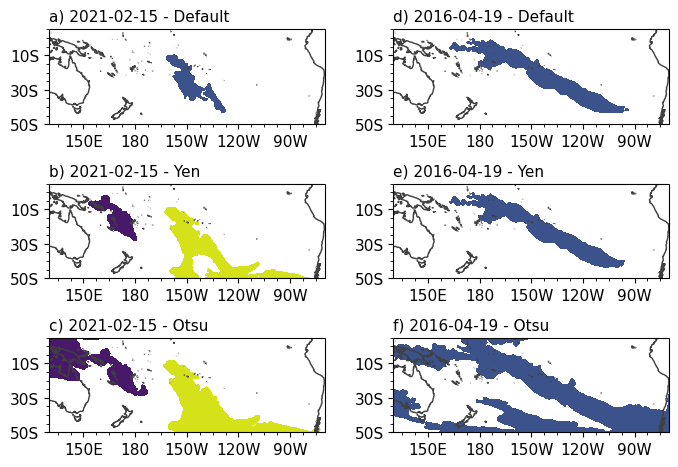

In [4]:
# Initialize variables for plot
# for panel numbering
alphabet = list(string.ascii_lowercase)
# for dates in title
date_format = "%Y%m%d.%S"

lat_north, lat_south = round(lats[0]), round(lats[-1])
lonticks = np.concatenate((np.arange(0, 180, 30), np.arange(-180, 0, 30)))
latticks = np.arange(-90, 110, 20)

set_fontsize()
fig, ax = plt.subplots(
    nrows=len(methods), ncols=len(lstdates), figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}
)
inc = 0
for i, idate in enumerate(lstdates):
    datetime_obj = datetime.strptime(idate, date_format)
    datetime_string = datetime_obj.strftime("%Y-%m-%d")
    for j, met in enumerate(methods):
        ax[j,i].contourf(
            lons,
            lats,
            np.ma.masked_where(cloud_bands_over_time_thres[inc] == 0, cloud_bands_over_time_thres[inc]),
            transform=ccrs.PlateCarree(),
        )
        ax[j,i].set_title(f"{alphabet[inc]}) {datetime_string} - {met}", loc="left", fontsize=11)
        ax[j,i].set_yticks(np.arange(-90, 110, 20), crs=ccrs.PlateCarree())
        ax[j,i].set_xticks(lonticks, crs=ccrs.PlateCarree())
        ax[j,i].set_yticks(latticks, crs=ccrs.PlateCarree())
        ax[j,i].xaxis.set_major_formatter(LON_FORMAT)
        ax[j,i].yaxis.set_major_formatter(LAT_FORMAT)
        ax[j,i].minorticks_on()
        ax[j,i].coastlines("50m", color="#404040")
        ax[j,i].set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
        ax[j,i].set_ylim([lat_south, lat_north])
        inc += 1

fig.subplots_adjust(wspace=0.25, hspace=0.001)
plt.show()
